In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import skimage.io
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model
from skimage.transform import (hough_line, hough_line_peaks,
                               probabilistic_hough_line)
from skimage.feature import canny
from skimage import data, color, feature, transform
from skimage.measure import LineModelND, ransac
from matplotlib import cm
from tqdm import tqdm
from scipy.cluster.vq import kmeans2

In [3]:
img = skimage.io.imread('./test-image2.png')

## We chose this initial image for testing for the obvious lines in the architecture and multiple vanishing points

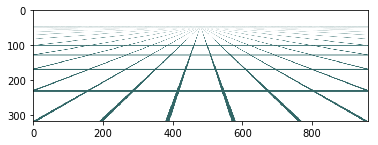

In [4]:
imshow(img)

In [5]:
image = skimage.color.rgb2gray(img)
edges = canny(image)

### The next two cells have code from http://scikit-image.org/docs/dev/auto_examples/edges/plot_line_hough_transform.html

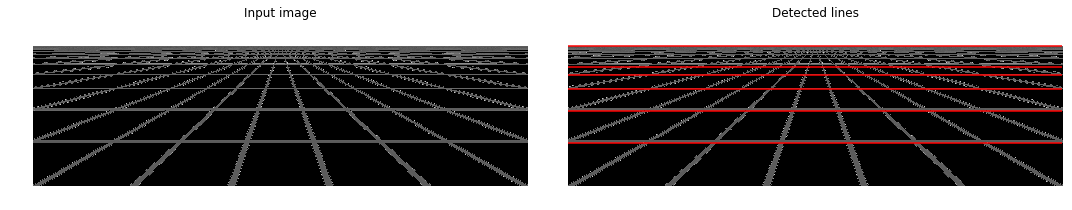

In [6]:
# Classic straight-line Hough transform
h, theta, d = hough_line(edges)

# Generating figure 1
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
ax = axes.ravel()

ax[0].imshow(image, cmap=cm.gray)
ax[0].set_title('Input image')
ax[0].set_axis_off()

ax[1].imshow(image, cmap=cm.gray)
for _, angle, dist in zip(*hough_line_peaks(h, theta, d)):
    y0 = (dist - 0 * np.cos(angle)) / np.sin(angle)
    y1 = (dist - image.shape[1] * np.cos(angle)) / np.sin(angle)
    ax[1].plot((0, image.shape[1]), (y0, y1), '-r')
ax[1].set_xlim((0, image.shape[1]))
ax[1].set_ylim((image.shape[0], 0))
ax[1].set_axis_off()
ax[1].set_title('Detected lines')

plt.tight_layout()
plt.show()

## In the next cell, we increased line_length drastically, this allowed us to only look at the major lines in the image and avoid lines that would not lead to the vanishing point

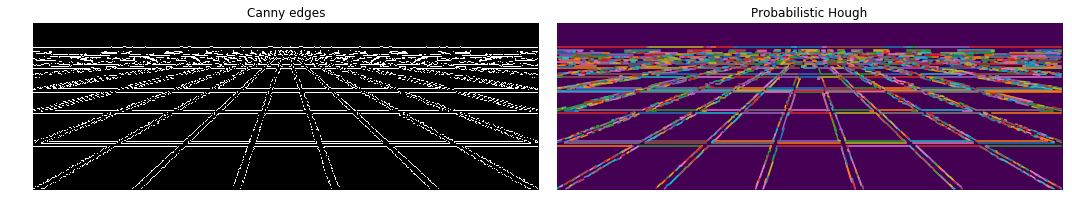

In [7]:
# Line finding using the Probabilistic Hough Transform
lines = probabilistic_hough_line(edges, threshold=10, line_length=3,
                                 line_gap=2)

# Generating figure 2
fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(edges, cmap=cm.gray)
ax[0].set_title('Canny edges')

ax[1].imshow(edges * 0)
for line in lines:
    p0, p1 = line
    ax[1].plot((p0[0], p1[0]), (p0[1], p1[1]))
ax[1].set_xlim((0, image.shape[1]))
ax[1].set_ylim((image.shape[0], 0))
ax[1].set_title('Probabilistic Hough')

for a in ax:
    a.set_axis_off()

plt.tight_layout()
plt.show()

In [8]:
def slope(x1, y1, x2, y2):
    if x2-x1 == 0:
        return 'undf'
    return (y2-y1)/(x2-x1)

## https://stackoverflow.com/questions/3252194/numpy-and-line-intersections

In [9]:
def get_intersect(a1, a2, b1, b2):
    """ 
    Returns the point of intersection of the lines passing through a2,a1 and b2,b1.
    a1: [x, y] a point on the first line
    a2: [x, y] another point on the first line
    b1: [x, y] a point on the second line
    b2: [x, y] another point on the second line
    """
    s = np.vstack([a1,a2,b1,b2])        # s for stacked
    h = np.hstack((s, np.ones((4, 1)))) # h for homogeneous
    l1 = np.cross(h[0], h[1])           # get first line
    l2 = np.cross(h[2], h[3])           # get second line
    x, y, z = np.cross(l1, l2)          # point of intersection
    if z == 0:                          # lines are parallel
        return (float('inf'), float('inf'))
    return (x/z, y/z)

In [10]:
pre_ransac_no_verts = []
for ele in lines:
    pre_ransac_no_verts.append(slope(ele[0][0], ele[0][1], ele[1][0], ele[1][1]))

## Remove vertical lines from the probablistic hough transform results, this will lessen the number of intersections not leading to vanishing points for the ransac algorithm

In [11]:
no_vert_lines = []
no_vert_slopes = []
horizontal_lines = []
for i in range(len(pre_ransac_no_verts)):
    if str(pre_ransac_no_verts[i]) == 'undf':
        continue
    elif abs(pre_ransac_no_verts[i]) < 2: 
        horizontal_lines.append(lines[i])
        continue
    no_vert_lines.append(lines[i])
    no_vert_slopes.append(pre_ransac_no_verts[i])


In [12]:
intersections = []
for i in tqdm(range(len(no_vert_lines) - 1)):
    for j in range(i+1, len(no_vert_lines)):
        cur_intersect = get_intersect(no_vert_lines[i][0], no_vert_lines[i][1], \
                                      no_vert_lines[j][0], no_vert_lines[j][1])
        # if points are parellel (inf, inf), do not include and go to next iteration
        if(str(cur_intersect[0]) == 'inf'):
            continue
        intersections.append(cur_intersect)

100%|██████████| 101/101 [00:00<00:00, 135.10it/s]


## The figure below shows all intersections of lines from the probablistic hough transform

100%|██████████| 4460/4460 [00:14<00:00, 304.17it/s]


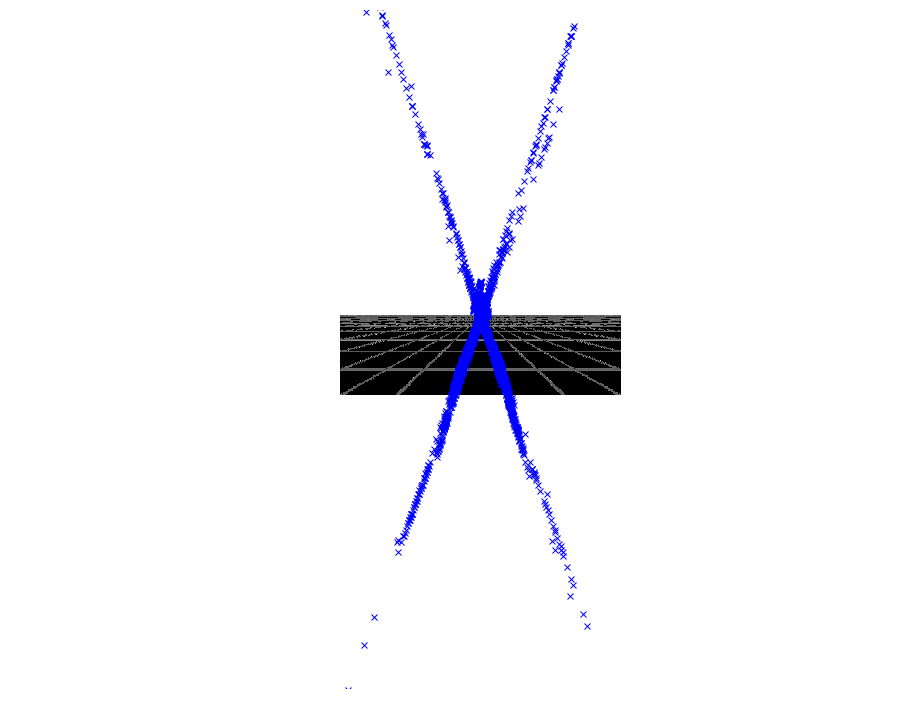

In [13]:
fig, axes = plt.subplots(figsize=(15,10))

axes.imshow(image, cmap=cm.gray)
for i in tqdm(range(len(intersections))):
    axes.plot(intersections[i][0],intersections[i][1], 'bx', label='point')
axes.set_xlim((-1000, image.shape[1]+1000))
axes.set_ylim((image.shape[0] + 1000, - 1000))
axes.set_axis_off()

plt.tight_layout()
plt.show()

In [19]:
horizontal_y_coordinates = []
for ele in horizontal_lines:
    horizontal_y_coordinates.append(ele[1][1])


In [22]:
max(horizontal_y_coordinates)

313

In [23]:
intersections_x = list(zip(*intersections))[0]
intersections_y = list(zip(*intersections))[1]

## https://stackoverflow.com/questions/52280944/python-finding-multiple-linear-trend-lines-in-a-scatter-plot

## The figure below shows the lines found from the ransac algorithm

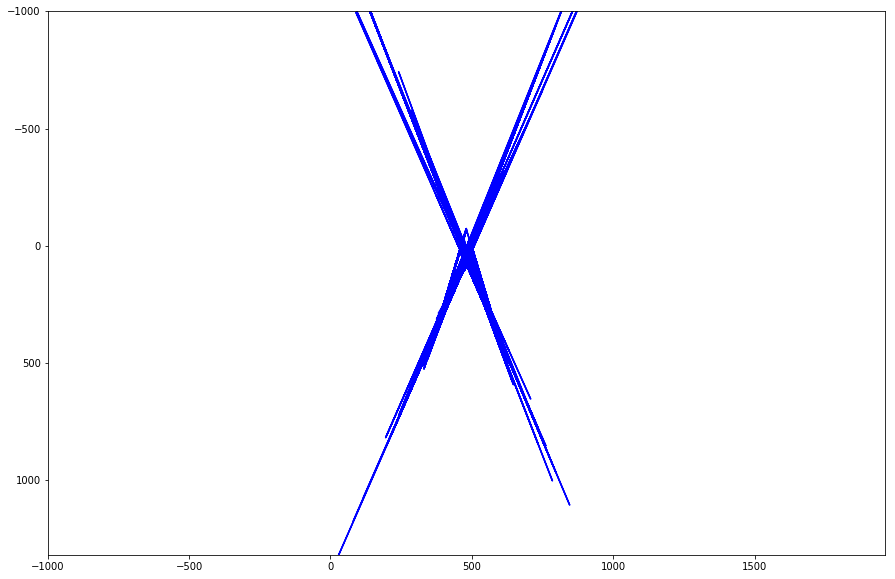

In [24]:
ransac_lines = []
idx = 0
fig, ax = plt.subplots(figsize=(15,10))

xs = np.array(intersections_x)
ys = np.array(intersections_y)

MIN_SAMPLES = 2

while len(xs) > MIN_SAMPLES:
    # build design matrix for linear regressor
    X = np.ones((len(xs), 2))
    X[:, 1] = xs

    ransac = linear_model.RANSACRegressor(
        residual_threshold=.3, min_samples=MIN_SAMPLES
    )

    res = ransac.fit(X, ys)

    # vector of boolean values, describes which points belong
    # to the fitted line:
    inlier_mask = ransac.inlier_mask_

    # plot point cloud:
    xinlier = xs[inlier_mask]
    yinlier = ys[inlier_mask]
    
    ransac_lines.append(list(zip(xinlier, yinlier)))

    ax.plot(xinlier, yinlier, "-b")

    # only keep the outliers:
    xs = xs[~inlier_mask]
    ys = ys[~inlier_mask]
        
ax.set_xlim((-1000, image.shape[1]+1000))
ax.set_ylim((image.shape[0] + 1000, - 1000))
plt.show()

## taking ransac lines, computing the intersection

In [25]:
ransac_intersections = []
for i in tqdm(range(len(ransac_lines) - 1)):
    for j in range(i+1, len(ransac_lines)):
        cur_intersect = get_intersect(ransac_lines[i][0], ransac_lines[i][1], \
                                      ransac_lines[j][0], ransac_lines[j][1])
        # if points are parellel (inf, inf), do not include and go to next iteration
        if(str(cur_intersect[0]) == 'inf'):
            continue
        ransac_intersections.append(cur_intersect)

100%|██████████| 73/73 [00:00<00:00, 174.05it/s]


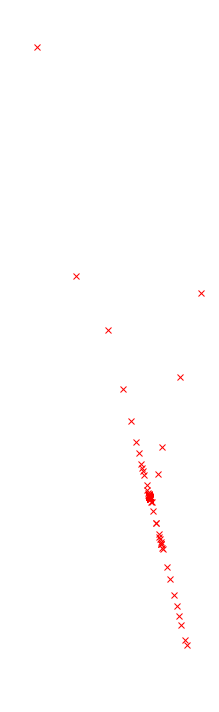

In [26]:
fig, axes = plt.subplots(figsize=(15,10))

axes.imshow(image, cmap=cm.gray)
for i in range(len(ransac_intersections)):
    axes.plot(ransac_intersections[i][0], ransac_intersections[i][1], 'bx', label='point', color='r')
axes.set_axis_off()

plt.tight_layout()
plt.show()

## removing intersections not near the horizon line

In [41]:
ransac_thresholded_intersections = []
for ele in ransac_intersections:
    if abs(ele[1] - min(horizontal_y_coordinates)) > 10:
           continue
    ransac_thresholded_intersections.append(ele)

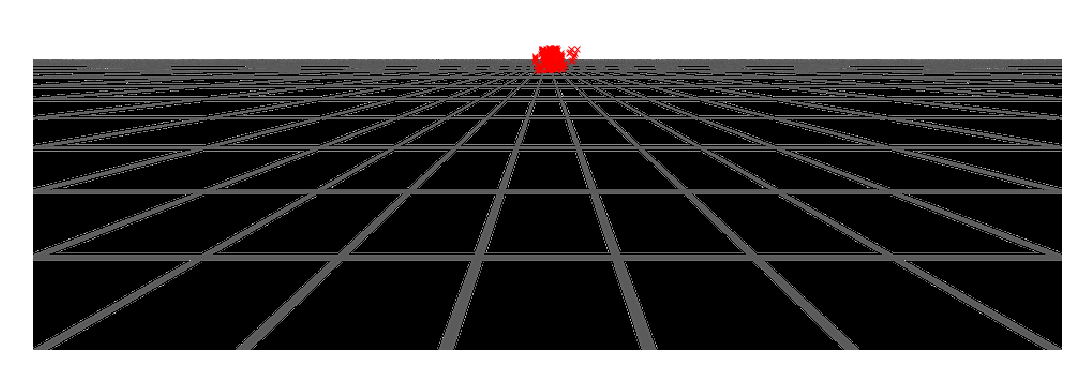

In [42]:
fig, axes = plt.subplots(figsize=(15,10))
axes.imshow(image, cmap=cm.gray)

for i in range(len(ransac_thresholded_intersections)):
        axes.plot(ransac_thresholded_intersections[i][0],ransac_thresholded_intersections[i][1], 'bx', label='point', color='r')

axes.set_axis_off()

plt.tight_layout()
plt.show()

## Clustering the ransac intersections so we can find the horizon line + vanishing points

In [ ]:
def point_distance(p1, p2):
    return sqrt((p2[0] - p1[0])**2 + (p2[1]-p2[0])**2)

In [ ]:
for i in range(len(ransac_intersections)):
    ransac_intersections[i] = list(ransac_intersections[i])

In [ ]:
intersection_neighbors = []
for i in range(len(ransac_intersections) - 1):
    count = 0
    for j in range(len(ransac_intersections)):
        if point_distance(ransac_intersections[i], ransac_intersections[j]) < 150:
            count += 1
    intersection_neighbors.append(count)

In [ ]:
max(intersection_neighbors)

In [ ]:
fig, axes = plt.subplots(figsize=(15,10))
axes.imshow(image, cmap=cm.gray)

for i in range(len(intersection_neighbors)):
    if intersection_neighbors[i] > 80:
        axes.plot(ransac_intersections[i][0],ransac_intersections[i][1], 'bx', label='point', color='r')

axes.set_axis_off()

plt.tight_layout()
plt.show()